In [91]:
filettl = 'Original' # 'RoChgOriginal' # Original

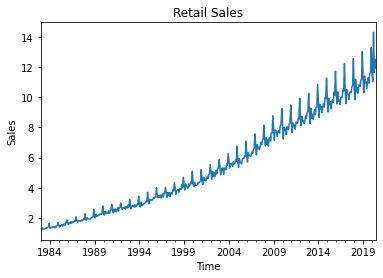

Stationary status check............
ADF Statistic: 3.680915
p-value: 1.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Original data has a trend. Converting to Stationary...
Successful stationary after 3 attempts::::::
ADF Statistic: -4.965175
p-value: 0.000026
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


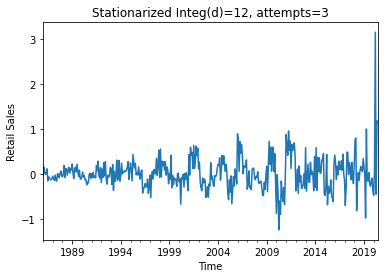

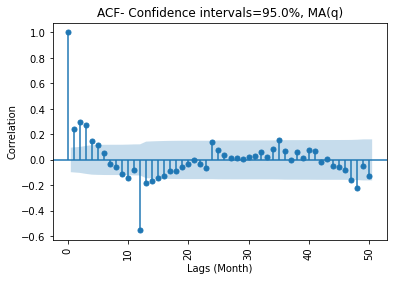

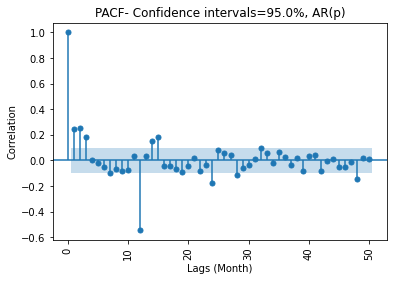

In [92]:
import pandas as pd
series = pd.read_csv(filettl+'.csv', header=0, index_col=0, parse_dates=True, squeeze=True) # parse_dates=Flase # squeeze=True: df to series
# series = train.squeeze() # parse_dates=Flase # squeeze=True: df to series



# https://machinelearningmastery.com/difference-time-series-dataset-python/
difflag=12 # the lag may be expected to be the period (width) of the seasonality
difforder=0 # number of stationary process attempts


from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot






# create a differenced series
def difference(dataset, interval=1):
    # return pd.DataFrame(dataset).diff(periods=interval)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
#     return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1, difforder=1):
#     x, x_diff = history, yhat # https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff
#     return np.r_[x, x_diff].cumsum().astype(int)
    if difforder<2:
        return yhat + history[-interval]
    else:
        tmp=yhat
        for i in range(1,difforder+1):
            tmp= tmp + history[-interval]
        return tmp







# plot
series.plot()
pyplot.title('Retail Sales')
pyplot.ylabel('Sales')
pyplot.xlabel('Time')
pyplot.savefig("pltstationchk"+filettl+".png")
pyplot.show()

stationarysuccess=False
result = adfuller(series)
tmpadf=result[0]
tmpcv1=list(result[4].items())[0][1]
print('Stationary status check............')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
if tmpadf<=tmpcv1: # already STATIONARY data
    stationarysuccess=True
    series.to_csv('stationary'+filettl+'.csv', header=False)
    print('<<<Data is already STATIONARY (no trend).>>>')
else: # not stationary yet
    print('Original data has a trend. Converting to Stationary...')
#     X = series.values
#     X = X.astype('float32')
    stationary = series
    while tmpadf>tmpcv1:
        difforder+=1
        if difforder>10:
            print('WARNING: failed to make stationary data after {} times!!!'.format(difforder-1))
            stationarysuccess=False
            break   
        months_in_year = difflag
        stationary = difference(stationary.values, months_in_year)
        stationary.index = series.index[months_in_year*difforder:] # difference *N times
        result = adfuller(stationary)
        tmpadf=result[0]
        tmpcv1=list(result[4].items())[0][1]
        if tmpadf<=tmpcv1: 
            stationarysuccess=True
            break
    # after while loop
    if stationarysuccess and difforder>0:
        print('Successful stationary after {} attempts::::::'.format(difforder))
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        # save
        stationary.to_csv('stationary'+filettl+'.csv', header=False)
        # plot
        stationary.plot()  
        pyplot.title('Stationarized Integ(d)={}, attempts={}'.format(difflag, difforder))
        pyplot.ylabel('Retail Sales')
        pyplot.xlabel('Time')
        pyplot.savefig("pltstationafter"+filettl+".png")
        pyplot.show()
    
           
            

series = read_csv('stationary'+filettl+'.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # squeeze=True: df to series
from statsmodels.graphics.tsaplots import plot_acf

a=0.05

plot_acf(series, alpha=a, lags=50)
pyplot.xlabel('Lags ({})'.format('Month'))
pyplot.xticks(rotation=90)
pyplot.ylabel('Correlation')
pyplot.title('ACF- Confidence intervals={}%, MA(q)'.format((1-a)*100))
pyplot.savefig("pltstationacf"+filettl+".png")
pyplot.show()

from statsmodels.graphics.tsaplots import plot_pacf
# series = read_csv('original.csv', header=0, index_col=0)
pltpacf = plot_pacf(series, alpha=a, lags=50)#, method='ywmle') # method : {'ywunbiased', 'ywmle', 'ols'}
pyplot.xlabel('Lags ({})'.format('Month'))
pyplot.xticks(rotation=90)
pyplot.ylabel('Correlation')
pyplot.title('PACF- Confidence intervals={}%, AR(p)'.format((1-a)*100))
pyplot.savefig("pltstationpacf"+filettl+".png")
pyplot.show()


<AxesSubplot:xlabel='ds'>

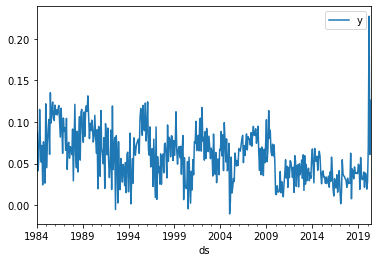

In [85]:
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

# mean (trendless), variance (amp) and covariance (mag), do not vary with time

# ADF (Augmented Dickey Fuller) Test
# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

# Differencing
# power transform, square root, and log transform

# Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
# Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
# Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.




import numpy as np
train = read_csv('original.csv', header=0, index_col=0, parse_dates=True) # squeeze df to series
# train = train[-100:]

train['y'] = np.log(train['y'])
train['y'] = train['y'] - train['y'].shift(12)

# train['y'].dropna().plot()

train.dropna(subset=['y'],inplace=True) 
train.plot()

In [86]:
train

,y
ds,
1984-01-01,0.088804
1984-02-01,0.086943
1984-03-01,0.041458
1984-04-01,0.057783
1984-05-01,0.115036
...,...
2020-02-01,0.070772
2020-03-01,0.226933
2020-04-01,0.060865


<AxesSubplot:xlabel='ds'>

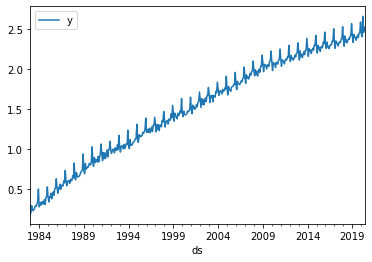

In [49]:
train.plot()

<AxesSubplot:xlabel='ds'>

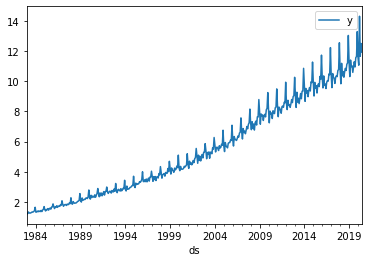

In [51]:
train.plot()

In [87]:
train

,y
ds,
1984-01-01,0.088804
1984-02-01,0.086943
1984-03-01,0.041458
1984-04-01,0.057783
1984-05-01,0.115036
...,...
2020-02-01,0.070772
2020-03-01,0.226933
2020-04-01,0.060865
